<a href="https://colab.research.google.com/github/pvh95/ML-Projects/blob/master/FAMD_nyc_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing: Numpy, Pandas, Scikit-Learn, Seaborn, Matplotlib**

In [1]:
import math
import numpy as np 
import pandas as pd
import sklearn 
import scipy
%matplotlib inline
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)


import missingno as msno
import warnings 
warnings.filterwarnings('ignore')
import copy 

# Uploading and Accessing the New York City Airbnb data from 2019, https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [2]:
from google.colab import files
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Looking at the Big Picture**
Welcome to our NYC (Not **NY**iregyhaza **C**ity) AirBnB Price Prediction Modelling Group or as we like to call ourselves Goal Diggers (No, **NOT** Gold Diggers)  
The data includes *latitude and longitude of properties, room_type, price, min nights, # of reviews, reviwews/month, host listing and days availabe for booking*.  

Our target variable is the price. 

# **Framing the problem**
1.   Business Objective: Prediction of any NYC Airbnb property price/night
2.   The Frame:

  *   A supervised learning task (as each instance comes with a price)
  *   A regression (specifically multiple and univariate regression) task as having many attributes for making prediction and only trying to predict a single value, respectively 
  *   Offline learning task aka once the system is trained, it is put into use w/o learning it anymore 

3. Performance Measure (Cost Function for Regression): 


*   **RMSE (Root Mean Square Error)** is typical for regression tasks. The underlying idea behind is how much the system typically makes in its predictions, w/ a heigher weight for large errors:
> $ RMSE(\textbf{X}, f)= \sqrt{\dfrac{1}{n} \sum_{i=1}^{n} \, (f( \textbf{x}_{i}) - y_{i})^2}$ 

  where n: # of instances in the data set; $\textbf{x}_i$ is a vector of containing all the attributes excl. the dependent variables (ala price) of the $i^{th}$ instance; $y_{i}$ is the output for that instance;  $f$ is the prediction function $==>$ $\hat{y_{i}} = f(\textbf{x}_i)$
*   **MAE (Mean Absolute Error)**   is another possibility cost function for a regression task: 
> $ MAE(\textbf{X}, f)= \dfrac{1}{n} \sum_{i=1}^{n} \, |f( \textbf{x}_{i}) - y_{i}|$

* Both RMSE and MAE are norms ($L_2$ and $L_1 \, $ respectively}. 
Let's see which one is better for our purpose.   




















In [3]:
nycAB_orig = pd.read_csv('gdrive/My Drive/NYC_AB_2019.csv')

In [ ]:
nycAB_orig.info()

In [ ]:
nycAB_orig.describe()

In [ ]:
msno.bar(nycAB_orig,sort='ascending',color='red')
plt.show()

In [ ]:
nycAB_orig['neighbourhood_group'].value_counts()

In [ ]:
nycAB_orig["room_type"].value_counts()

In [ ]:
nycAB_orig.head()

In [ ]:
print(f"Average of price per night : ${nycAB_orig.price.mean():.2f}")
print(f"Maximum price per night : ${nycAB_orig.price.max()}")
print(f"Minimum price per night : ${nycAB_orig.price.min()}") #There are some free houses 

Average of price per night : $152.72
Maximum price per night : $10000
Minimum price per night : $0


# **Framing the problem** (cont.)
*   The plot shows tail-heaviness at the right end, that is, in our context, there are very few outliers $==>$ **RMSE** is the preferred choice for a cost function/performance measurement tool  

# **A sneak peak into the data structure**
*   head() and info() method (see above): 
  *   Each row depicts a property with a unique id 
  *   16 features, 48895 instances
  *   6 attributes are text, all other are numerical
  *   In the info() method, it can be clearly seen that *last_review* and *reviews_per_month* have more than 10.052 missing entries => should treat this later on. 

*   describe() method (see above): 
  *   Some descriptive statisitics could be read for each numerical feature 







In [ ]:
#nycAB_orig.hist(bins=30, figsize=(20,14))
nycAB_orig.hist(bins=20, figsize=(17,10))

In [ ]:
#logPrice = np.log(nycAB_orig["price"])
#plt.figure(figsize=(10,7))
#sns.set(style="whitegrid")
#ax = sns.boxplot(x=logPrice)

In [ ]:
sns.set(style="whitegrid")
sns.distplot(nycAB_orig["price"], bins = 30)

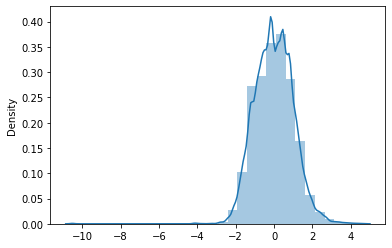

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
trialdf = pd.DataFrame(nycAB_orig, columns= ["price"])
pt = preprocessing.PowerTransformer(method='yeo-johnson')
modified_price = pt.fit_transform(trialdf)
sns.distplot(modified_price, bins = 30)  #With Yeo-Johnson transformation our price variable now looks more like a Gaussaian distro

In [ ]:
nycAB_orig.isnull().sum()

# **A sneak peak into the data structure** (cont.)
*   Histogram (what can be noticed): 
  *   Most histograms tends to skewed to the left, aka tail-heavy at the right end $-->$ Try to transform them to have more bell-shaped-like distro.
  *   Features gave wide range of scales. Feature scaling is needed before feeding into the system. 
  *   latitude and longitude histograms' resemble a normal-like distribution $-->$ Properties concentrate on more of a central location of NYC (like Manhattan, Brooklyn) - it will be seen through data visulaization, too.    





# **Creating a Train, Validation, Test Set**
*   Train/Test = 80/20
*   Train ---> TrainReduced/Valid = 80/20
*   Want to make sure our test set is representative of the universe so a good idea to implement **stratified sampling**. In other words, the data points are allocated to their respective homogenous subgroups called strata, and the appropirate # of data entries are sampled from each stratum. This way, representativeness can be ensured.
*   Doing Stratified sampling according to *neighboorhood_group* or *room_type*
*   Creating strata based on a better representative feature 






In [ ]:
sns.set(style="whitegrid")
sns.countplot(nycAB_orig['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Neighbourhood Group')
nycAB_orig["neighbourhood_group"].value_counts() / len(nycAB_orig)

In [ ]:
sns.set(style="whitegrid")
sns.countplot(nycAB_orig['room_type'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Room Type')
nycAB_orig["room_type"].value_counts() / len(nycAB_orig)

### Creating Train and Test Set 

In [ ]:
'''
from sklearn.model_selection import StratifiedShuffleSplit

randState = 69  ## initialize random state for replicability 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= randState)

#for train_index, test_index in split.split(nycAB_orig, nycAB_orig["neighbourhood_group"]):
for train_index, test_index in split.split(nycAB_orig, nycAB_orig["room_type"]):
  stratified_train_set_trial = nycAB_orig.loc[train_index]
  stratified_test_set_trial = nycAB_orig.loc[test_index]

#stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 
stratified_test_set_trial["room_type"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 
'''

In [ ]:
stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)  #Checking the distro of test set 

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

randState = 69  ## initialize random state for replicability 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= randState)

for train_index, test_index in split.split(nycAB_orig, nycAB_orig["neighbourhood_group"]):
#for train_index, test_index in split.split(nycAB_orig, nycAB_orig["room_type"]):
  stratified_train_set = nycAB_orig.loc[train_index]
  stratified_test_set = nycAB_orig.loc[test_index]

stratified_test_set["neighbourhood_group"].value_counts() / len(stratified_test_set)  #Checking the distro of test set 
#stratified_test_set["room_type"].value_counts() / len(stratified_test_set)  #Checking the distro of test set 

Manhattan        0.442990
Brooklyn         0.411187
Queens           0.115861
Bronx            0.022293
Staten Island    0.007669
Name: neighbourhood_group, dtype: float64

In [ ]:
stratified_test_set["room_type"].value_counts() / len(stratified_test_set)

In [ ]:
(stratified_test_set_trial["neighbourhood_group"].value_counts() / len(stratified_test_set_trial)) / (stratified_test_set["neighbourhood_group"].value_counts() / len(stratified_test_set)) - 1

In [ ]:
(stratified_test_set_trial["room_type"].value_counts() / len(stratified_test_set_trial)) / (stratified_test_set["room_type"].value_counts() / len(stratified_test_set)) -1

Should base our stratified sampling on *neighbourhood_group*, the differences are more distributed among the categories within neighboor_hood_group than in the case of *room_type*

In [ ]:
len(stratified_train_set)

In [8]:
dummyIndex = pd.Index(np.arange(len(stratified_train_set)))
dummyStrat_trainSet = stratified_train_set.set_index(dummyIndex)   #Creating a DummyTrainSet by setting a new index that is in-order, important when it comes to do stratified 

### Creating Reduced Train and Validation Set 

In [9]:
for trainRed_index, valid_index in split.split(dummyStrat_trainSet, dummyStrat_trainSet["neighbourhood_group"]):
#for trainRed_index, valid_index in split.split(dummyStrat_trainSet, dummyStrat_trainSet["room_type"]):
  stratified_trainRed_set = dummyStrat_trainSet.loc[trainRed_index]
  stratified_valid_set = dummyStrat_trainSet.loc[valid_index]

stratified_valid_set["neighbourhood_group"].value_counts() / len(stratified_valid_set)  #Checking the distro of test set
#stratified_valid_set["room_type"].value_counts() / len(stratified_valid_set)  #Checking the distro of test set  

Manhattan        0.442996
Brooklyn         0.411171
Queens           0.115925
Bronx            0.022367
Staten Island    0.007541
Name: neighbourhood_group, dtype: float64

# **Creating a Test Set** (cont.)
*   5 strata --- Brooklyn, Manhattan, Queens, Staten Island, Bronx
*   Comparing the test set with the universe, it could be seen we achived our goals of having very similar location distribution in the test set compared to the original data set $==>$ representiveness is ensured. 
*   After creating test set, we put it on hold until doing fine-tuning on training set
*   From now on, we are gonna exploring training set, but before that the training set needs to be copied 



In [10]:
nycAB = copy.deepcopy(stratified_train_set)  #Creating a copy of the training set and gonna tinker the copied version 

# **Looking at the Data Structure Again and Now Tinkering it** 
1.   Visualizations
2.   Sepaerating the predictors and the target variable as we would not want to apply the same transformations to the predictors and target values
3.   Now we are allowed to make modifications/transformations/adjustments on the (copied) training set 
4.  Data Cleaning and Imputatuion 
5.   Feature Engineering (Feature Selection, Feature Extraction) 
6.   Transoformation Scaling 





In [ ]:
nycAB.info()

In [ ]:
nycAB.describe()

In [ ]:
nycAB.isnull().sum()

In [ ]:
nycAB['neighbourhood_group'].value_counts()

In [ ]:
sns.set(style="whitegrid")
sns.countplot(nycAB['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Neighbourhood Group')
nycAB["neighbourhood_group"].value_counts() / len(nycAB)

In [ ]:
nycAB['room_type'].value_counts()

In [ ]:
sns.set(style="whitegrid")
sns.countplot(nycAB['room_type'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.title('Room Type')
nycAB["room_type"].value_counts() / len(nycAB)

In [ ]:
print(f"Average of price per night : ${nycAB.price.mean():.2f}")
print(f"Median price per night : ${nycAB.price.median():.2f}")
print(f"Maximum price per night : ${nycAB.price.max()}")
print(f"Minimum price per night : ${nycAB.price.min()}") #There are some free houses 

Average of price per night : $152.30
Median price per night : $107.00
Maximum price per night : $10000
Minimum price per night : $0


# Visualizing the data 
*   Try to visualize train set properties on a scatter plot based on their longitude and latitude data for discovering high-density areas and how prices vary in those areas 



In [ ]:
num_vars = [col for col in nycAB.columns if nycAB[col].dtype != 'O' and nycAB[col].dtype != bool]
print('The number of numerical variables:', str(len(num_vars)))
print()
print('The numerical variables are :', num_vars)

The number of numerical variables: 10

The numerical variables are : ['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [ ]:
def boxplot_for_outlier(df,columns):
    count = 0
    fig, ax =plt.subplots(nrows=5,ncols=2, figsize=(9,18))
    for i in range(5):
        for j in range(2):
            sns.boxplot(x = df[columns[count]], palette="Set2",ax=ax[i][j])
            count = count+1

boxplot_for_outlier(nycAB,num_vars)

In [ ]:
nycAB.hist(bins=30, figsize=(30,22))

Latitude and Longitude follows a kinda normal distributions $==>$ properties concantrated around on those areas mostly (Manhattan and Brooklyn as we would see later on)

In [ ]:
sns.countplot(nycAB['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Neighbourhood Group')

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x='neighbourhood_group',y='availability_365',palette='bright', data=nycAB)
plt.title('Neighbourhood Group and Availability')

In [ ]:
sns.countplot(nycAB['room_type'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.title('Room Type')

In [ ]:
sns.countplot(nycAB['room_type'], hue=nycAB['neighbourhood_group'], palette="bright")
fig = plt.gcf()
fig.set_size_inches(15,8)
plt.title('Room Type Based on Neighboorhood Group')

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = nycAB['longitude'], y= nycAB['latitude'], hue=nycAB['neighbourhood_group'], palette='bright')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = nycAB['longitude'], y= nycAB['latitude'], hue=nycAB['room_type'], palette='colorblind')
plt.show()

# Price plot

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
trialdf = pd.DataFrame(nycAB, columns= ["price"])
pt = preprocessing.PowerTransformer(method='yeo-johnson')
YJ_modified_price_array = pt.fit_transform(trialdf)
YJ_modified_price_df = pd.DataFrame(YJ_modified_price_array, columns = trialdf.columns, index = trialdf.index)

In [ ]:
nycAB.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, figsize=(10,10),
    c=YJ_modified_price_array, cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

# Neighbourhood


In [ ]:
len(nycAB['neighbourhood'].unique())

221

In [ ]:
top5Neighbourhood = nycAB.neighbourhood.value_counts().head(5)
sns.barplot(x = top5Neighbourhood.index, y = top5Neighbourhood.values, palette = 'bright')
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.title('TOP5 Neighbourhood')

In [ ]:
nycAB.neighbourhood.value_counts().head(5)

Williamsburg          3098
Bedford-Stuyvesant    2948
Harlem                2117
Bushwick              1986
Hell's Kitchen        1568
Name: neighbourhood, dtype: int64

In [ ]:
nycAB.neighbourhood.value_counts().tail(5)

New Dorp          1
Rossville         1
Richmondtown      1
West Farms        1
Fort Wadsworth    1
Name: neighbourhood, dtype: int64

# **Discover Correlations**
*   Our interest is how price correlates w/ other features 
*   Even though it's important to measure correlation, it may miss capturing non-linear realtionships between attributes 






In [ ]:
#corrMtx = nycAB.corr()
#corrMtx["price"].sort_values(ascending=False)

In [ ]:
#plt.figure(figsize=(15,8))
#sns.heatmap(corrMtx, annot=True, linewidths=0.1, cmap='Reds')
#plt.title('Correlation Matrix Heatmap')

# **Experimanting with attributes**

In [ ]:
nycAB_trial = copy.deepcopy(nycAB)
nycAB_trial2 = copy.deepcopy(nycAB)

In [ ]:
nycAB_trial.isnull().sum()

In [ ]:
nycAB_trial.drop(columns=['id', 'host_id', 'name', 'host_name', 'last_review'], inplace = True)

In [ ]:
nycAB_trial['reviews_per_month']

In [ ]:
#fillna with median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
nycAB_miss_value_df = nycAB_trial[['reviews_per_month']]
imputer.fit(nycAB_miss_value_df)
X_nycAB_miss_value_df = imputer.transform(nycAB_miss_value_df)
nycAB_miss_value_df = pd.DataFrame(X_nycAB_miss_value_df, columns=nycAB_miss_value_df.columns, index=nycAB_miss_value_df.index)

In [ ]:
#print(X_nycAB_miss_value_df[0:10])
#print(nycAB_miss_value_df[0:10])
nycAB_miss_value_df.shape

(39116, 1)

In [ ]:
nycAB_trial['reviews_per_month'] = nycAB_miss_value_df
nycAB_trial.isnull().sum() 

In [ ]:
nycAB_trial['months'] = nycAB_trial['number_of_reviews']/nycAB_trial['reviews_per_month']

In [ ]:
corrMtx = nycAB_trial.corr()
corrMtx["price"].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(corrMtx, annot=True, linewidths=0.1, cmap='Reds')
plt.title('Correlation Matrix Heatmap')

In [ ]:
nycAB_trial.drop(['number_of_reviews'], axis=1, inplace=True)

In [ ]:
nycAB_trial['months'] 

8098     50.000000
39990     1.000000
31033    14.855876
45316     0.000000
34516    11.290323
           ...    
9995     47.368421
403      23.140496
38269     7.352941
41091     4.580153
41415     4.234528
Name: months, Length: 39116, dtype: float64

# Seperating predictors from target variable

In [293]:
nycAB = stratified_train_set.drop('price', axis=1)
nycAB_tRed_set = stratified_trainRed_set.drop('price', axis=1)
nycAB_valid_set = stratified_valid_set.drop('price', axis=1)
X_test = stratified_test_set.drop('price', axis=1)


nycAB_target = pd.DataFrame(stratified_train_set, columns=["price"])
nycAB_tRed_target = pd.DataFrame(stratified_trainRed_set, columns=["price"])
nycAB_valid_target = pd.DataFrame(stratified_valid_set, columns=["price"])
Y_test = pd.DataFrame(stratified_test_set, columns= ["price"])

# **Data Cleaning, Imputing, Feature Selection, and Handling Categrocial Variables**

**dropUnnecessary** function: 
* Dropping duplicates
* Determining a dropList, which is a user parameter
* Dropping *reviews_per_month* because it has a strong correlation with *number_of_reviews* (see the corr mtx heatmap) --- aka multicollinearity

**dropCategorical** function: 
* Dropping Categorical features for later numerical data transformation reason

**puredVersion** function: 
* Just amalgamate the two above-mentioned function into one. It's worth breaking down into smaller functions and merge them into one function, which calls those "piece" functions because of easier debugging.



In [294]:
def dropUnnecessary(df, df_target, dropList):  
  df_new = df.drop(dropList, axis=1)  #dropping features in the "dropList" list 
  return df_new, df_target

def dropCategorical(df):
  dropList1 = df.select_dtypes(include=['object']).columns
  df_num = df.drop(dropList1, axis=1)
  return df_num 

def puredVersion(df, df_target, dropList):
  imputed, imputed_target = dropUnnecessary(df, df_target, dropList)
  imputed_num = dropCategorical(imputed)

  return imputed, imputed_num, imputed_target


# **Transformation Pipelines and Feature Scaling**  
*   Two categorical attributes: *neighbourhood_group* and *room_type* for OneHotEncoding 
*   For having better performance, we may need to use Yeo-Johnson transformation as feature scaling. In ourcase, it transforms mainly heavy-tailed distro features (see hist above) into somewhat normal-like distro. 
Yeo-Johnson is kind of an extension to Box-Cox with the ability of handling 0 and negative values. Concurrently, we are doing standardization (as it is the default parameter in the PowerTrnsformer() class: more details @ https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html )  

* Standardization: It subtracts the mean so the standardized values have a zero mean then it divides by the Standard Deviation $==>$ The resulting distro has **unit variance** 
*  (Min-Max scaling is also a solution but it bounds a value to specific range, usually 0-1 by subtracting the min then divede it by max-min)

In [295]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [296]:
def target_var_transformer(imputed_target, pT):
  if pT is None: 
    pT = preprocessing.PowerTransformer(method='yeo-johnson') #transforming the target variable
    targetTransform = pT.fit(imputed_target)
    imputed_target_ready_array = targetTransform.transform(imputed_target)
    imputed_target_ready = pd.DataFrame(imputed_target_ready_array, columns = imputed_target.columns, index = imputed_target.index)

  else:
    targetTransform = pT
    imputed_target_ready_array = targetTransform.transform(imputed_target)
    imputed_target_ready = pd.DataFrame(imputed_target_ready_array, columns = imputed_target.columns, index = imputed_target.index)

  return imputed_target_ready, targetTransform

In [297]:
def num_var_transformer(imputed_num, full_pipeline, strategy):
  if strategy == 'imputer':
    num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median"))]) 
  elif strategy == 'y-j':
    num_pipeline = Pipeline([('y-j', PowerTransformer(method='yeo-johnson'))]) 

  num_attr = list(imputed_num)

  if full_pipeline is None: 
    full_pipeline = ColumnTransformer([
      ("num", num_pipeline, num_attr)])

    fittedColumnTransform = full_pipeline.fit(imputed_num)
    imputed_num_array = fittedColumnTransform.transform(imputed_num)
    imputed_num_ready = pd.DataFrame(imputed_num_array, columns = imputed_num.columns, index = imputed_num.index)

    if (strategy == 'imputer') and ('number_of_reviews' not in dropList):
      imputed_num_ready['months'] = imputed_num_ready['number_of_reviews'] / imputed_num_ready['reviews_per_month']
      imputed_num_ready.drop(['number_of_reviews'], axis=1, inplace=True)

    
  else:
    fittedColumnTransform = full_pipeline
    imputed_num_array = fittedColumnTransform.transform(imputed_num)
    imputed_num_ready = pd.DataFrame(imputed_num_array, columns = imputed_num.columns, index = imputed_num.index)

    if (strategy == 'imputer') and ('number_of_reviews' not in dropList):
      imputed_num_ready['months'] = imputed_num_ready['number_of_reviews'] / imputed_num_ready['reviews_per_month']
      imputed_num_ready.drop(['number_of_reviews'], axis=1, inplace=True)

  return imputed_num_ready, fittedColumnTransform


In [298]:
#For FAMD, not onehotencode categorical variables

def concat_num_cat_var(imputed, imputed_num, desired_cat_attr):
  temp_cat_df = imputed[desired_cat_attr]
  imputed_concat = copy.deepcopy(imputed_num)

  imputed_concat = pd.concat([imputed_concat, temp_cat_df], axis = 1 )

  return imputed_concat

In [299]:
def df_proccessed(df, df_target, dropList, desired_cat_attr, full_pipeline1 = None, full_pipeline2 = None, pT = None):
  imputed, imputed_num, imputed_target = puredVersion(df, df_target, dropList)

  imputed_target, targetTransform = target_var_transformer(imputed_target, pT)

  strategies = ['imputer', 'y-j']
  for strategy in strategies:
    if strategy == 'imputer':
      imputed_num, fittedColumnTransform1 = num_var_transformer(imputed_num, full_pipeline1, strategy)
    else: 
      imputed_num, fittedColumnTransform2 = num_var_transformer(imputed_num, full_pipeline2, strategy)

  imputed_concat = concat_num_cat_var(imputed, imputed_num, desired_cat_attr)
  imputed_concat.drop(['latitude'], axis=1, inplace=True)

  return imputed_concat, imputed_target, fittedColumnTransform1, fittedColumnTransform2, targetTransform


In [300]:
dropList = ['name','host_name','last_review','neighbourhood','host_id', 'id']
desired_cat_attr = ['room_type','neighbourhood_group']
imputed_concat, imputed_target, fittedColumnTransform1, fittedColumnTransform2, targetTransform =  df_proccessed(nycAB, nycAB_target, dropList, desired_cat_attr, full_pipeline1 = None, full_pipeline2 = None, pT = None)

In [ ]:
imputed_concat.head()

,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,months,room_type,neighbourhood_group
8098,0.344259,-0.334960,-1.624189,-0.682770,-1.188832,1.153203,Entire home/apt,Brooklyn
39990,0.700254,1.018875,0.310928,-0.682770,0.434167,-1.125691,Entire home/apt,Brooklyn
31033,-0.807839,-1.285534,1.710091,0.759828,-1.188832,0.139508,Private room,Manhattan
45316,-0.601922,1.716625,-0.027605,-0.682770,1.075445,-1.435793,Entire home/apt,Manhattan
34516,3.732211,-1.285534,-0.175198,0.759828,1.164766,-0.048977,Entire home/apt,Queens


In [301]:
imputed_concat.head()

,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,months,room_type,neighbourhood_group
8098,0.344259,-0.334960,-1.624189,-0.682770,-1.188832,1.153203,Entire home/apt,Brooklyn
39990,0.700254,1.018875,0.310928,-0.682770,0.434167,-1.125691,Entire home/apt,Brooklyn
31033,-0.807839,-1.285534,1.710091,0.759828,-1.188832,0.139508,Private room,Manhattan
45316,-0.601922,1.716625,-0.027605,-0.682770,1.075445,-1.435793,Entire home/apt,Manhattan
34516,3.732211,-1.285534,-0.175198,0.759828,1.164766,-0.048977,Entire home/apt,Queens


# **Selecting and Trainaing Models** on Reduced Training Set and **Evaluating** on the Validation Set

In [302]:
pip install prince

### FAMD

In [303]:
#Train+Dev FAMD fit and transform

import prince

dropList = ['name','host_name','last_review','neighbourhood', 'host_id', 'id']
desired_cat_attr = ['room_type','neighbourhood_group']
#desired_cat_attr = ['room_type']
nycAB_ready, nycAB_imputed_target, fittedColumnTransform1_tr_dev, fittedColumnTransform2_tr_dev, targetTransform_tr_dev =  df_proccessed(nycAB, nycAB_target, dropList, desired_cat_attr, full_pipeline1 = None, full_pipeline2 = None, pT = None)  

fitTransfromFAMD_tr_dev = prince.FAMD(n_components = 10, n_iter=10, engine = 'auto', random_state = randState).fit(nycAB_ready)
nycAB_ready = fitTransfromFAMD_tr_dev.transform(nycAB_ready)

In [304]:
sum(fitTransfromFAMD_tr_dev.explained_inertia_)

0.9511413328166206

In [305]:
#Test FAMD fit transform
X_test_ready, Y_test_ready, _, _, _ = df_proccessed(X_test, Y_test, dropList, desired_cat_attr, full_pipeline1 = fittedColumnTransform1_tr_dev, full_pipeline2 = fittedColumnTransform2_tr_dev, pT = targetTransform_tr_dev)
X_test_ready = fitTransfromFAMD_tr_dev.transform(X_test_ready)


In [306]:
from sklearn.model_selection import train_test_split
X_trRed, X_valid, Y_trRed, Y_valid = train_test_split(nycAB_ready, nycAB_imputed_target, test_size=0.2, random_state=randState)

----------------------------

## **Linear Regression** --- Plain Vanila

### Transformation of the data on the REDUCED Training Set

### Training of the REDUCED Training Set  


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin1_reg = LinearRegression()

lin1_reg.fit(X_trRed, Y_trRed)
Y_trRedPred_lin1 = lin1_reg.predict(X_trRed)
lin1_trRedPred_mse = mean_squared_error(Y_trRed, Y_trRedPred_lin1)
lin1_trRedPred_rmse = np.sqrt(lin1_trRedPred_mse)

print("LinReg Train RMSE:", lin1_trRedPred_rmse)

LinReg Train RMSE: 0.7157310105800763


In [26]:
Y_validPred_lin1 = lin1_reg.predict(X_valid)

lin1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_lin1)
lin1_validPred_rmse = np.sqrt(lin1_validPred_mse)

print("LinReg Validation RMSE:", lin1_validPred_rmse)

LinReg Validation RMSE: 0.7040556663620396


## **Linear Regression** --- Plain Vanila but w/ a K-fold Cross-Validation Spice (Using entire full Training Set) 
*   The reason why we do not need validation set is defined in the definition of K-fold Cross-Validation (let's say K=6, so the training set will be randomly split into 6 folds (aka subsets), and the chosen model (now Lin Reg) will be trained and evaluated 6 times, **choosing a different fold every time** as a validation set and training on the other 5 folds.
In this way, we could also get a glimpse of whether the training set is overfitted or not. 

*   By default Sklearn's CV expects a utility function instead of cost function used by Regression models' as performance measurement. So the scoring function used by Sklearn's CV has to be a negated MSE, that's why in the code you see $\text{-lin_score}$



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin1_reg = LinearRegression()
lin1_reg.fit(nycAB_ready, nycAB_imputed_target)
Y_trPred_lin1 = lin1_reg.predict(nycAB_ready)
lin1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_lin1)
lin1_trPred_rmse = np.sqrt(lin1_trPred_mse)

print("LinReg Train RMSE:", lin1_trPred_rmse)

LinReg Train RMSE: 0.7133749904926758


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

lin1_scores = cross_val_score(lin1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
lin1_rmse_scores = np.sqrt(-lin1_scores)
 
display_scores(lin1_rmse_scores)

Scores: [0.71431087 0.70993167 0.7371339  0.7147807  0.70991486 0.69536943]
Mean: 0.713573572267701
Standard deviation: 0.012349967647752338


## **Linear Regression w/ Stochastic Gradient Descent** 

In [29]:
from sklearn.linear_model import SGDRegressor

sgd1_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty="l2", eta0=0.1, random_state = randState)
sgd1_reg.fit(X_trRed, Y_trRed)
Y_trPred_sgd1 = sgd1_reg.predict(X_trRed)
sgd1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_sgd1)
sgd1_trPred_rmse = np.sqrt(sgd1_trPred_mse)

print("LinReg w/ SGD Train RMSE:", sgd1_trPred_rmse)

LinReg w/ SGD Train RMSE: 0.7206693495892224


In [30]:
Y_validPred_sgd1 = sgd1_reg.predict(X_valid)

sgd1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_sgd1)
sgd1_validPred_rmse = np.sqrt(sgd1_validPred_mse)

print("LinReg w/ SGD Validation RMSE:", sgd1_validPred_rmse)

LinReg w/ SGD Validation RMSE: 0.7089645541498117


In [31]:
sgd1_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty="l2", eta0=0.1, random_state = randState)

sgd1_reg.fit(nycAB_ready, nycAB_imputed_target)
Y_trPred_sgd1 = sgd1_reg.predict(nycAB_ready)
sgd1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_sgd1)
sgd1_trPred_rmse = np.sqrt(sgd1_trPred_mse)

print("LinReg w/ SGD Train RMSE:", sgd1_trPred_rmse)

LinReg w/ SGD Train RMSE: 0.7164311183425008


In [32]:
from sklearn.linear_model import SGDRegressor

sgd1_scores = cross_val_score(sgd1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6) #Cross-validation
sgd1_rmse_scores = np.sqrt(-sgd1_scores)
 
display_scores(sgd1_rmse_scores)

Scores: [0.71823294 0.71583361 0.74539702 0.72284861 0.7147044  0.70610977]
Mean: 0.7205210572543868
Standard deviation: 0.012199436605150348


## **SVM w/ Linear Kernel** 



In [49]:
from sklearn.svm import SVR
svmLin1_reg = SVR(kernel="linear", C=2, epsilon=0.1)
svmLin1_reg.fit(X_trRed, Y_trRed)

Y_trPred_svmLin1 = svmLin1_reg.predict(X_trRed)
svmLin1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_svmLin1)
svmLin1_trPred_rmse = np.sqrt(svmLin1_trPred_mse)
 
print("SVM w/ Linear Kernel Train RMSE:", svmLin1_trPred_rmse)

SVM w/ Linear Kernel Train RMSE: 0.7177936770924072


In [50]:
Y_validPred_svmLin1 = svmLin1_reg.predict(X_valid)

svmLin1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_svmLin1)
svmLin1_validPred_rmse = np.sqrt(svmLin1_validPred_mse)

print("SVM w/ Linear Kernel Validation RMSE:", svmLin1_validPred_rmse)

SVM w/ Linear Kernel Validation RMSE: 0.7066617898546269


## **SVM w/ Linear Kernel** --- w/ Cross-Validation 

In [51]:
from sklearn.svm import SVR
svmLin1_reg = SVR(kernel="linear", C=2.0, epsilon=0.5)
svmLin1_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_svmLin1 = svmLin1_reg.predict(nycAB_ready)
svmLin1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_svmLin1)
svmLin1_trPred_rmse = np.sqrt(svmLin1_trPred_mse)
 
print("SVM w/ Linear Kernel Train RMSE:", svmLin1_trPred_rmse)

SVM w/ Linear Kernel Train RMSE: 0.7140398709344105


In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

svmLin1_scores = cross_val_score(svmLin1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
svmLin1_rmse_scores = np.sqrt(-svmLin1_scores)
 
display_scores(svmLin1_rmse_scores)

Scores: [0.71574286 0.71048584 0.73735218 0.71556519 0.71069324 0.69545242]
Mean: 0.7142152892861561
Standard deviation: 0.012368173541573602


## **SVM w/ Gaussian Kernel** 

### Training of the REDUCED Training Set  

In [148]:
svmGauss1 = SVR(kernel="rbf", C=2.0, gamma = 0.2, epsilon=0.5) #gamma 0.2
svmGauss1.fit(X_trRed, Y_trRed)

Y_trPred_svmGauss1 = svmGauss1.predict(X_trRed)
svmGauss1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_svmGauss1)
svmGauss1_trPred_rmse = np.sqrt(svmGauss1_trPred_mse)

print("SVM w/ Gaussian Kernel Train RMSE:", svmGauss1_trPred_rmse)

SVM w/ Gaussian Kernel Train RMSE: 0.6457484037425448


### Evaluation on the Validation Set


In [149]:
Y_validPred_svmGauss1 = svmGauss1.predict(X_valid)

svmGauss1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_svmGauss1)
svmGauss1_validPred_rmse = np.sqrt(svmGauss1_validPred_mse)

print("SVM w/ Gaussian Kernel Validation RMSE:", svmGauss1_validPred_rmse)

SVM w/ Gaussian Kernel Validation RMSE: 0.6478645200355757


In [150]:
svmGauss1 = SVR(kernel="rbf", C=2.0, gamma = 0.2, epsilon=0.5)
svmGauss1.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_svmGauss1 = svmGauss1.predict(nycAB_ready)
svmGauss1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_svmGauss1)
svmGauss1_trPred_rmse = np.sqrt(svmGauss1_trPred_mse)

print("SVM w/ Gaussian Kernel Train RMSE:", svmGauss1_trPred_rmse)

SVM w/ Gaussian Kernel Train RMSE: 0.6437572536668337


In [151]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

svmGauss1_scores = cross_val_score(svmGauss1, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
svmGauss1_rmse_scores = np.sqrt(-svmGauss1_scores)
 
display_scores(svmGauss1_rmse_scores)

Scores: [0.65780378 0.65771622 0.68091911 0.65942539 0.64778804 0.63325904]
Mean: 0.6561519292856955
Standard deviation: 0.01427902717239612


## **RandomForest** --- Plain Vanila

### Training of the REDUCED Training Set  

In [53]:
from sklearn.ensemble import RandomForestRegressor

RF1_reg = RandomForestRegressor(n_estimators=100, random_state= randState)
RF1_reg.fit(X_trRed, Y_trRed)

Y_trPred_RF1 = RF1_reg.predict(X_trRed)
RF1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_RF1)
RF1_trPred_rmse = np.sqrt(RF1_trPred_mse)

print("RF Vanila Train RMSE:", RF1_trPred_rmse)

RF Vanila Train RMSE: 0.2551333204697651


### Evaluation on the Validation Set


In [54]:
Y_validPred_RF1 = RF1_reg.predict(X_valid)

RF1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_RF1)
RF1_validPred_rmse = np.sqrt(RF1_validPred_mse)

print("RF Vanila Validation RMSE:", RF1_validPred_rmse)

RF Vanila Validation RMSE: 0.6768420616142578


#### The Plain RandomForest seems to overfit badly, that is, it performs much worse on the validation set. 

Now let's look at it using Cross-Validation (also using the full training set)

In [55]:
from sklearn.ensemble import RandomForestRegressor

RF1_reg = RandomForestRegressor(n_estimators=100, random_state= randState)
RF1_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_RF1 = RF1_reg.predict(nycAB_ready)
RF1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_RF1)
RF1_trPred_rmse = np.sqrt(RF1_trPred_mse)

print("RF Vanila Train RMSE:", RF1_trPred_rmse)

RF Vanila Train RMSE: 0.2544724975935045


In [56]:
from sklearn.model_selection import cross_val_score

RF1_scores = cross_val_score(RF1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
RF1_rmse_scores = np.sqrt(-RF1_scores)
 
display_scores(RF1_rmse_scores)

Scores: [0.66920712 0.68048863 0.69680488 0.68360077 0.66486274 0.66312498]
Mean: 0.676348186497388
Standard deviation: 0.011874223093532298


## **RandomForest** --- with parameters 

In [57]:
RF2_reg = RandomForestRegressor(n_estimators=100, max_depth=4, max_leaf_nodes = 10 , n_jobs = -1, random_state = randState, bootstrap = True)
RF2_reg.fit(X_trRed, Y_trRed)

Y_trPred_RF2 = RF2_reg.predict(X_trRed)
RF2_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_RF2)
RF2_trPred_rmse = np.sqrt(RF2_trPred_mse)

print("RF w/ parameters Train RMSE:", RF2_trPred_rmse)

RF w/ parameters Train RMSE: 0.754017615688587


In [58]:
Y_validPred_RF2 = RF2_reg.predict(X_valid)

RF2_validPred_mse = mean_squared_error(Y_valid, Y_validPred_RF2)
RF2_validPred_rmse = np.sqrt(RF2_validPred_mse)

print("RF w/ parameters Validation RMSE:", RF2_validPred_rmse)

RF w/ parameters Validation RMSE: 0.7488740832462979


In [59]:
from sklearn.ensemble import RandomForestRegressor

RF2_reg = RandomForestRegressor(n_estimators=100, max_depth=4, max_leaf_nodes = 10 , n_jobs = -1, random_state = randState, bootstrap = True)
RF2_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_RF2 = RF2_reg.predict(nycAB_ready)
RF2_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_RF2)
RF2_trPred_rmse = np.sqrt(RF2_trPred_mse)

print("RF w/ parameters Train RMSE:", RF2_trPred_rmse)

RF w/ parameters Train RMSE: 0.7558283968256941


In [60]:
RF2_scores = cross_val_score(RF2_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
RF2_rmse_scores = np.sqrt(-RF2_scores)
 
display_scores(RF2_rmse_scores)

Scores: [0.75146973 0.75206104 0.77536029 0.75848861 0.75703437 0.74279928]
Mean: 0.7562022204418849
Standard deviation: 0.009934252009499923


## **Gradient Boosting - XGBoost** --- Vanila

In [ ]:
import xgboost as xgb

xgb1_reg = xgb.XGBRegressor()
xgb1_reg.fit(X_trRed, Y_trRed)

Y_trPred_xgb1 = xgb1_reg.predict(X_trRed)
xgb1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_xgb1)
xgb1_trPred_rmse = np.sqrt(xgb1_trPred_mse)

print("XGB Vanila Regression Train RMSE:", xgb1_trPred_rmse)

[18:09:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB Vanila Regression Train RMSE: 0.6737214346784536


In [ ]:
Y_validPred_xgb1 = xgb1_reg.predict(X_valid)

xgb1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_xgb1)
xgb1_validPred_rmse = np.sqrt(xgb1_validPred_mse)

print("XGB Vanila Validation RMSE:", xgb1_validPred_rmse)

XGB Vanila Validation RMSE: 0.6742207220821189


In [ ]:
xgb1_scores = cross_val_score(xgb1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
xgb1_rmse_scores = np.sqrt(-xgb1_scores)
 
display_scores(xgb1_rmse_scores)

[18:09:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:10:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:10:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Scores: [0.68302935 0.68118738 0.7075467  0.68502829 0.68021254 0.66587734]
Mean: 0.6838135999089969
Standard deviation: 0.012294475885092639


## **Gradient Boosting - XGBoost** --- with Parameters

In [207]:
import xgboost as xgb
xgb2_reg = xgb.XGBRegressor(max_depth=5, learning_rate = 0.05, objective='reg:squarederror',  n_estimators=200, booster = 'gbtree', n_jobs = -1, gamma = 10, subsample=0.9) #n_estimators = 200
xgb2_reg.fit(X_trRed, Y_trRed)

Y_trPred_xgb2 = xgb2_reg.predict(X_trRed)
xgb2_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_xgb2)
xgb2_trPred_rmse = np.sqrt(xgb2_trPred_mse)

print("XGB2 Regression Train RMSE:", xgb2_trPred_rmse)

XGB2 Regression Train RMSE: 0.6569366574490568


In [208]:
Y_validPred_xgb2 = xgb2_reg.predict(X_valid)

xgb2_validPred_mse = mean_squared_error(Y_valid, Y_validPred_xgb2)
xgb2_validPred_rmse = np.sqrt(xgb2_validPred_mse)

print("XGB2 Validation RMSE:", xgb2_validPred_rmse)

XGB2 Validation RMSE: 0.6663656499822656


In [178]:
xgb2_reg = xgb.XGBRegressor(max_depth=5, learning_rate = 0.1, objective='reg:squarederror',  n_estimators=200, booster = 'gbtree', n_jobs = -1, gamma = 10) #n_estimators = 200
xgb2_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_xgb2 = xgb2_reg.predict(nycAB_ready)
xgb2_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_xgb2)
xgb2_trPred_rmse = np.sqrt(xgb2_trPred_mse)

print("XGB2 Regression Train RMSE:", xgb2_trPred_rmse)

XGB2 Regression Train RMSE: 0.6605055891195143


In [112]:
xgb2_scores = cross_val_score(xgb2_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
xgb2_rmse_scores = np.sqrt(-xgb2_scores)
 
display_scores(xgb2_rmse_scores)

Scores: [0.67895362 0.67842483 0.70005913 0.68174819 0.67511579 0.65855136]
Mean: 0.6788088194169409
Standard deviation: 0.01214075154778963


## **Bagging and Pasting**



In [245]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

bagging1_reg = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators = 200, max_samples = 1000, bootstrap = True, n_jobs = - 1
)

bagging1_reg.fit(X_trRed, Y_trRed)

Y_trPred_bagging1 = bagging1_reg.predict(X_trRed)
bagging1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_bagging1)
bagging1_trPred_rmse = np.sqrt(bagging1_trPred_mse)

print("Bagging Regression Train RMSE:", bagging1_trPred_rmse)

Bagging Regression Train RMSE: 0.6583652974833717


In [246]:
Y_validPred_bagging1 = bagging1_reg.predict(X_valid)

bagging1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_bagging1)
bagging1_validPred_rmse = np.sqrt(bagging1_validPred_mse)

print("Bagging Validation RMSE:", bagging1_validPred_rmse)

Bagging Validation RMSE: 0.6693613014710371


In [247]:
from sklearn.ensemble import BaggingRegressor
bagging1_reg = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators = 200, max_samples = 1000, bootstrap = True, n_jobs = - 1
)

bagging1_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_bagging1 = bagging1_reg.predict(nycAB_ready)
bagging1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_bagging1)
bagging1_trPred_rmse = np.sqrt(bagging1_trPred_mse)

print("Bagging Regression Train RMSE:", bagging1_trPred_rmse)

Bagging Regression Train RMSE: 0.6609062012464259


In [248]:
bagging1_scores = cross_val_score(bagging1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
bagging1_rmse_scores = np.sqrt(-bagging1_scores)
 
display_scores(bagging1_rmse_scores)

Scores: [0.6767296  0.67454889 0.70337424 0.67811896 0.67043757 0.65912399]
Mean: 0.6770555414521345
Standard deviation: 0.013326241474629547


## **Voting Regression**
The following regressions will be used in Voting Regressions 

*   Linear Regression (lin1_reg)
*   SVM w/ RBF kernel (svmGauss1)
*   Random Forest (RF2_reg)


In [249]:
from sklearn.ensemble import VotingRegressor
voting1_reg = VotingRegressor(
    estimators = [('xgb', xgb2_reg), ('svmGauss', svmGauss1), ('bagging', bagging1_reg)])

voting1_reg.fit(X_trRed, Y_trRed)

Y_trPred_voting1 = voting1_reg.predict(X_trRed)
voting1_trPred_mse = mean_squared_error(Y_trRed, Y_trPred_voting1)
voting1_trPred_rmse = np.sqrt(voting1_trPred_mse)

print("Voting Regression Train RMSE:", voting1_trPred_rmse)

Voting Regression Train RMSE: 0.647678062215611


In [250]:
Y_validPred_voting1 = voting1_reg.predict(X_valid)

voting1_validPred_mse = mean_squared_error(Y_valid, Y_validPred_voting1)
voting1_validPred_rmse = np.sqrt(voting1_validPred_mse)

print("voting1 Validation RMSE:", voting1_validPred_rmse)

voting1 Validation RMSE: 0.6551185312792174


In [251]:
from sklearn.ensemble import VotingRegressor
voting1_reg = VotingRegressor(
    estimators = [('xgb', xgb2_reg), ('svmGauss', svmGauss1), ('bagging', bagging1_reg)])

voting1_reg.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_voting1 = voting1_reg.predict(nycAB_ready)
voting1_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_voting1)
voting1_trPred_rmse = np.sqrt(voting1_trPred_mse)

print("Voting Regression Train RMSE:", voting1_trPred_rmse)

Voting Regression Train RMSE: 0.6470818793129557


In [252]:
voting1_scores = cross_val_score(voting1_reg, nycAB_ready, nycAB_imputed_target, scoring="neg_mean_squared_error", cv=6)
voting1_rmse_scores = np.sqrt(-voting1_scores)
 
display_scores(voting1_rmse_scores)

Scores: [0.66497024 0.66278664 0.68799326 0.66571842 0.65779939 0.64352251]
Mean: 0.6637984093459431
Standard deviation: 0.013156586209300066


# **Choosing 4-6 Promising Models and Fine-tune those models with the help of GridSearchCV**

In [253]:
from sklearn.model_selection import GridSearchCV

## **RandomForest**

In [ ]:
param_grid_RF3 = [
    {'n_estimators': [10, 50], 'max_depth' : [3,6], 'min_samples_split' : [2,4], 'max_features' : [3,6]},
    {'bootstrap': [False], 'n_estimators': [10, 50], 'max_depth' : [3,6], 'min_samples_split' : [2,4], 'max_features' : [3,6]},
]

RF3_reg = RandomForestRegressor()

grid_search_RF3 = GridSearchCV(RF3_reg, param_grid_RF3, cv=6, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_RF3.fit(nycAB_ready, nycAB_imputed_target)

GridSearchCV(cv=6, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [ ]:
print(grid_search_RF3.best_params_)
print()
print(grid_search_RF3.best_estimator_)

{'max_depth': 6, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 50}

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [ ]:
cvRes_RF3 = grid_search_RF3.cv_results_
for mean_score, params in zip(cvRes_RF3["mean_test_score"], cvRes_RF3["params"]):
  if params == grid_search_RF3.best_params_:
    print(np.sqrt(-mean_score), params) #206.78076493823684

0.6941263534538009 {'max_depth': 6, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 50}


## **Regularized Linear Regression** w/ SGD 

In [256]:
param_grid_sgd2 = [
    {'loss' : ['squared_loss'], 'penalty' : ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.03, 0.1],
     'epsilon' : [0.01, 0.05, 0.1], 'random_state' : [randState], 'eta0' : [0.01, 0.05, 0.1], 'learning_rate' : ['optimal', 'invscaling']},
]

sgd2_reg = SGDRegressor()
grid_search_sgd2 = GridSearchCV(sgd2_reg, param_grid_sgd2, cv=6, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_sgd2.fit(nycAB_ready, nycAB_imputed_target)

GridSearchCV(cv=6, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_star...e),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.005, 0.03, 0.1],
                          'epsilon': [0.01, 0.05, 0.1],
                          'eta0': [0.01, 0.05, 0.1],
                          'learning_rate': ['optimal', 'invscaling'],


In [257]:
print(grid_search_sgd2.best_params_)
print()
print(grid_search_sgd2.best_estimator_)

{'alpha': 0.005, 'epsilon': 0.01, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'squared_loss', 'penalty': 'l2', 'random_state': 69}

SGDRegressor(alpha=0.005, average=False, early_stopping=False, epsilon=0.01,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=69,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [258]:
cvRes_sgd2 = grid_search_sgd2.cv_results_
for mean_score, params in zip(cvRes_sgd2["mean_test_score"], cvRes_sgd2["params"]):
  if params == grid_search_sgd2.best_params_:
    print(np.sqrt(-mean_score), params) #212.22885387569934 (Actually a slightly worse than the barely parametrized sgd1)

0.7138993030462183 {'alpha': 0.005, 'epsilon': 0.01, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'squared_loss', 'penalty': 'l2', 'random_state': 69}


In [310]:
sgd2_reg2 = grid_search_sgd2.best_estimator_
sgd2_reg2.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_sgd2_reg2 = sgd2_reg2.predict(nycAB_ready)
sgd2_reg2_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_sgd2_reg2)
sgd2_reg2_trPred_rmse = np.sqrt(sgd2_reg2_trPred_mse)

print("SGD Train RMSE:", sgd2_reg2_trPred_rmse)

SGD Train RMSE: 0.7153986095631865


## **Gradient Boosting - XGBoost** 

In [259]:
param_grid_xgb3 = [
    {'booster': ['gbtree'], 'objective': ['reg:squarederror'], 'n_estimators': [100, 200, 500], 'learning_rate':[0.03, 0.1, 0.3], 
     'max_depth' : [4,5], 'gamma' : [5,10,20], 'subsample': [0,2, 0.6, 0.9], 'n_jobs' : [-1], 'random_state' : [randState]}
]

xgb3_reg = xgb.XGBRegressor()

grid_search_xgb3 = GridSearchCV(xgb3_reg, param_grid_xgb3, cv=6, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_xgb3.fit(nycAB_ready, nycAB_imputed_target)

GridSearchCV(cv=6, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
             iid='deprecated', n_jobs=None,
             param_grid=[{'booster': ['gbtree'], 'gamma': [5, 10, 20],
                          'learning_rate': [0.03, 0.1, 0.3],
                          'max_depth': [4, 5], 'n_estimators': [100, 200, 500],
                          'n_jobs': [-1], 'objective': ['reg:squarede

In [260]:
print(grid_search_xgb3.best_params_)
print()
print(grid_search_xgb3.best_estimator_)

{'booster': 'gbtree', 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squarederror', 'random_state': 69, 'subsample': 0.9}

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=69, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)


In [261]:
cvRes_xgb3 = grid_search_xgb3.cv_results_
for mean_score, params in zip(cvRes_xgb3["mean_test_score"], cvRes_xgb3["params"]):
  if params == grid_search_xgb3.best_params_:
    print(np.sqrt(-mean_score), params) #Worse than what we could ahived when we did it in bagging1

0.6670521724376182 {'booster': 'gbtree', 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'n_jobs': -1, 'objective': 'reg:squarederror', 'random_state': 69, 'subsample': 0.9}


In [309]:
xgb3_reg2 = grid_search_xgb3.best_estimator_
xgb3_reg2.fit(nycAB_ready, nycAB_imputed_target)

Y_trPred_xgb3_reg2 = xgb3_reg2.predict(nycAB_ready)
xgb3_reg2_trPred_mse = mean_squared_error(nycAB_imputed_target, Y_trPred_xgb3_reg2)
xgb3_reg2_trPred_rmse = np.sqrt(xgb3_reg2_trPred_mse)

print("XGB Train RMSE:", xgb3_reg2_trPred_rmse)

XGB Train RMSE: 0.6205489240837285


# **Last Steps** 

The winner model is the SVR with Gaussian kernel (svmGauss1)

## **Running the final, selected model on the Test Set**

In [277]:
final_pred = svmGauss1.predict(X_test_ready)

final_mse = mean_squared_error(Y_test_ready, final_pred)
final_rmse = np.sqrt(final_mse)
print(final_rmse) 

0.6658913507277759
